#### 测试 Hastings_Powell 模型是否为混沌态

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

In [20]:
@njit
def HP(x, t, b1, *args):
    res = np.zeros_like(x)
    a1 = 5.
    # b1 = 3.
    a2 = 0.1
    b2 = 2.
    d1 = 0.4
    d2 = 0.01

    f_1 = a1 * x[0] / (1 + b1 * x[0])
    f_2 = a2 * x[1] / (1 + b2 * x[1])

    res[0] = x[0] * (1 - x[0]) - f_1 * x[1]
    res[1] = f_1 * x[1] - f_2 * x[2] - d1 * x[1]
    res[2] = f_2 * x[2] - d2 * x[2]

    return res

@njit
def jac(x, t, b1, *args):
    res = np.zeros((x.shape[0], x.shape[0]))
    a1 = 5.
    # b1 = 3.
    a2 = 0.1
    b2 = 2.
    d1 = 0.4
    d2 = 0.01

    res[0, 0] = 1 - 2 * x[0] - (a1 * x[1]) / (1 + b1 * x[0])**2
    res[0, 1] = a1 * x[0] / (1 + b1 * x[0])

    res[1, 0] = (a1 * x[1]) / (1 + b1 * x[0])**2
    res[1, 1] = a1 * x[0] / (1 + b1 * x[0]) - d1 - (a2 * x[2]) / (1 + b2 * x[1])**2
    res[1, 2] = a2 * x[1] / (1 + b2 * x[1])

    res[2, 1] = (a2 * x[2]) / (1 + b2 * x[1])**2
    res[2, 2] = a2 * x[1] / (1 + b2 * x[1]) - d2

    return res

In [21]:
@njit
def rk4_step(x, t, dt, f, *args):
    k1 = f(x, t, *args)
    k2 = f(x + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = f(x + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = f(x + dt * k3, t + dt, *args)
    return x + (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit
def mLCE_jit(x0, f, jac, n_forward, n_compute, dt, *args):
    """
    Parameters:
        x0 (numpy.ndarray)：初始条件。
        f（function）: ẋ = f(x, t) 或 x_(n 1) = f(x_n) 的函数 f。
        jac（function）: f 相对于 x 的雅可比行列式。
        n_forward (int): Number of steps before starting the mLCE computation.
        n_compute (int): Number of steps to compute the mLCE, can be adjusted using keep_evolution.
        dt（float）: 两个时间步之间的时间间隔。
        *args :  f 和 jac 需要修改的量
    """
    t = 0
    x = x0
    dim = len(x0)
    # 初始化
    for _ in range(n_forward):
        x = rk4_step(x, t, dt, f, *args)
        t += dt

    # Compute the mLCE
    mLCE = 0.
    W = np.random.rand(dim)
    W = W / np.linalg.norm(W)

    for _ in range(n_compute):
        # w = system.next_LTM(w)
        jacobian = jac(x, t, *args)
        k1 = jacobian @ W
        k2 = jacobian @ (W + (dt / 2.) * k1)
        k3 = jacobian @ (W + (dt / 2.) * k2)
        k4 = jacobian @ (W + dt * k3)
        W = W + (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

        # system.forward(1, False)
        x = rk4_step(x, t, dt, f, *args)
        t += dt

        mLCE += np.log(np.linalg.norm(W))
        W = W / np.linalg.norm(W)

    mLCE = mLCE / (n_compute * dt)

    return mLCE

@njit
def LCE_jit(x0, f, jac, n_forward, n_compute, dt, *args):
    """
    Parameters:
        x0 (numpy.ndarray)：初始条件。
        f（function）: ẋ = f(x, t) 或 x_(n 1) = f(x_n) 的函数 f。
        jac（function）: f 相对于 x 的雅可比行列式。
        n_forward (int): Number of steps before starting the mLCE computation.
        n_compute (int): Number of steps to compute the mLCE, can be adjusted using keep_evolution.
        dt（float）: 两个时间步之间的时间间隔。
        *args :  f 和 jac 需要修改的量
    """
    t = 0
    # x = x0
    x = np.ascontiguousarray(x0)
    dim = len(x0)
    # 初始化
    for _ in range(n_forward):
        x = rk4_step(x, t, dt, f, *args)
        t += dt

    # Compute the mLCE
    W = np.eye(dim)
    LCE = np.zeros(int(dim))

    for _ in range(n_compute):
        # w = system.next_LTM(w)
        jacobian = jac(x, t, *args)
        jacobian = np.ascontiguousarray(jacobian)
        W = np.ascontiguousarray(W)
        k1 = jacobian @ W
        k2 = jacobian @ (W + (dt / 2.) * k1)
        k3 = jacobian @ (W + (dt / 2.) * k2)
        k4 = jacobian @ (W + dt * k3)
        W = W + (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

        # system.forward(1, False)
        x = rk4_step(x, t, dt, f, *args)
        t += dt

        W, R = np.linalg.qr(W)
        LCE += np.log(np.abs(np.diag(R)))

    LCE = LCE / (n_compute * dt)

    return LCE

In [22]:
x0 = np.asarray([1., 1., 1.])
dt = 1e-2

T_init = int(1e6)
T_cal = int(1e6)

In [23]:
# mLCE = mLCE_jit(x0, HP, jac, T_init, T_cal, dt)
# LCE = LCE_jit(x0, HP, jac, T_init, T_cal, dt)

In [24]:
b1_list = np.linspace(2., 6.2, 100)

In [25]:
@njit(parallel=True)
def parallel_LCE(b1_list, x0, f, jac, T_init, T_cal, dt, *args):
    n = len(b1_list)
    LCE_values = np.zeros((n, 3))
    for i in prange(n):
        b1 = b1_list[i]
        LCE_values[i] = LCE_jit(x0, f, jac, T_init, T_cal, dt, b1, *args)

    # print(mLCE_values)
    return LCE_values

In [26]:
mLCE_values = parallel_LCE(b1_list, x0, HP, jac, T_init, T_cal, dt)

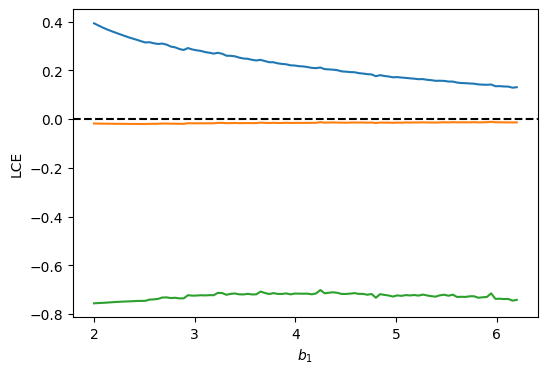

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(b1_list, mLCE_values)

plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

plt.ylabel("LCE")
plt.xlabel("$b_1$")
plt.show()